# Load data

The data is loaded from the preprocessed excel files.

In [ ]:
import pandas as pd #For reading files + data manipulation
import matplotlib.pyplot as plt  #For plotting
import numpy as np  #For data manipulation and calculations

from statsmodels.tsa.arima.model import ARIMA #For ARIMA modelling

from sklearn.metrics import root_mean_squared_error #For model evaluation

In [42]:
#Load in the processed data 
df_commodities = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx')[['Date','Price','% Change', 'Ticker']]
df_stocks = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx')[['Date', 'Price', '% Return', 'Ticker']]
df_exchange_rate = pd.read_excel('Data/Processed/DAILY_EXCHANGE_RATES.xlsx')[['Date','Mid', '% Change', 'Ticker']]

In [43]:
print(df_commodities.head())
print(df_stocks.head())
print(df_exchange_rate.head())

        Date      Price   % Change     Ticker
0 2018-01-02  50.781433  68.251837  HHGAS-FDS
1 2018-01-03  50.641342  -0.275871  HHGAS-FDS
2 2018-01-04  37.605713 -25.741081  HHGAS-FDS
3 2018-01-05  37.438774  -0.443919  HHGAS-FDS
4 2018-01-08  23.359003 -37.607457  HHGAS-FDS
        Date  Price  % Return     Ticker
0 2018-01-02  204.2  1.139178  AKERBP-NO
1 2018-01-03  207.0  1.371205  AKERBP-NO
2 2018-01-04  208.2  0.579710  AKERBP-NO
3 2018-01-05  209.6  0.672430  AKERBP-NO
4 2018-01-08  211.2  0.763359  AKERBP-NO
        Date       Mid  % Change  Ticker
0 2018-01-02  8.370757 -0.273562  CHFNOK
1 2018-01-03  8.306228 -0.770886  CHFNOK
2 2018-01-04  8.296742 -0.114203  CHFNOK
3 2018-01-05  8.254831 -0.505150  CHFNOK
4 2018-01-08  8.278486  0.286559  CHFNOK


In [44]:
#Check data types, everything ok
print(df_commodities.dtypes)
print(df_stocks.dtypes)
print(df_exchange_rate.dtypes)

#Check for missing values, everything ok
print(df_commodities.isnull().sum())
print(df_stocks.isnull().sum())
print(df_exchange_rate.isnull().sum())

Date        datetime64[ns]
Price              float64
% Change           float64
Ticker              object
dtype: object
Date        datetime64[ns]
Price              float64
% Return           float64
Ticker              object
dtype: object
Date        datetime64[ns]
Mid                float64
% Change           float64
Ticker              object
dtype: object
Date        0
Price       0
% Change    0
Ticker      0
dtype: int64
Date        0
Price       0
% Return    0
Ticker      0
dtype: int64
Date        0
Mid         0
% Change    0
Ticker      0
dtype: int64


In [45]:
#Refine column names
df_commodities.columns = ['Date', 'Price', 'Change_percent', 'Ticker']
df_stocks.columns = ['Date', 'Price', 'Change_percent', 'Ticker']
df_exchange_rate.columns = ['Date', 'Price', 'Change_percent', 'Ticker']

print(df_commodities.head())
print(df_stocks.head())
print(df_exchange_rate.head())

        Date      Price  Change_percent     Ticker
0 2018-01-02  50.781433       68.251837  HHGAS-FDS
1 2018-01-03  50.641342       -0.275871  HHGAS-FDS
2 2018-01-04  37.605713      -25.741081  HHGAS-FDS
3 2018-01-05  37.438774       -0.443919  HHGAS-FDS
4 2018-01-08  23.359003      -37.607457  HHGAS-FDS
        Date  Price  Change_percent     Ticker
0 2018-01-02  204.2        1.139178  AKERBP-NO
1 2018-01-03  207.0        1.371205  AKERBP-NO
2 2018-01-04  208.2        0.579710  AKERBP-NO
3 2018-01-05  209.6        0.672430  AKERBP-NO
4 2018-01-08  211.2        0.763359  AKERBP-NO
        Date     Price  Change_percent  Ticker
0 2018-01-02  8.370757       -0.273562  CHFNOK
1 2018-01-03  8.306228       -0.770886  CHFNOK
2 2018-01-04  8.296742       -0.114203  CHFNOK
3 2018-01-05  8.254831       -0.505150  CHFNOK
4 2018-01-08  8.278486        0.286559  CHFNOK


In [46]:
stocks_dictionary = {}

for key, values in df_stocks.groupby('Ticker'):
    stocks_dictionary[key] = {
        'data': values[['Date', 'Change_percent']],
    }


# Test for stationarity 
A crucial assumption of the ARIMA models is stationarity. A stationary process is a time series whose statistical properties, such as mean, variance and autocorrelation are constant over time (Brooks pg.248). The behavior of the series is independent of when one observes it. 

There are several reasons for why stationarity is desirable. Firstly, shocks may persist infinitely in a non-stationary process. Random disturbances may cause permanent shifts in the series, making it difficult for models that assume mean-reverting properties to predict future values. Additionally, two non-stationary series can move together over time, producing artificially high $R^2$ despite having no true relationship. This effect is called spurious regressions and can result from trending behavior misinterpreted as correlation. Lastly, non-stationary data can cause the t-ratios to not follow a t distribution, making hypothesis testing about the regression parameters less reliable (Brooks pg.334-336). 

Since ARIMA relies on data being stationary, tests to detect non-stationarity are conducted. The Augmented Dicky-Fuller (ADF) Test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests are two statistical methods to investigate stationarity (Brooks pg. 347). This project will use both ADF and KPSS, as they test opposite things, and thus complement each other. The null hypothesis of ADF is that the time series is non-stationary, while KPSS’s null hypothesis is that the time series is stationary.

Both of these tests are pre-implemented in the Statsmodels package in Python. Note that the tests are conducted with a significane level of 5%, which is deemed to be industry standard.


## Check stationarity of prices

Prices are known to be non-stationary and follow a clear trend. To confirm this, ADF and KPSS test are run on all stock and commodities prices, as well as exchange rate values.  As expected,  most of these prices and values are non-stationary, and cannot be used as input to an ARIMA model. Interestingly, the stock prices of AkerBP (AKERBP-NO) and Vår Energi (VAR-NO), as well as the commodity price of Natural gas (HNNGAS-FDS) show signs of stationarity, with the ADF test and KPSS test returning conflicting results. This can be due to the prices of these tickers having a relatively stable trend.

In [47]:
#Check stock prices for stationarity, using ADF and KPSS tests, for each ticker
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import warnings
def check_stationarity(data, title, returns = False):

    results = []
    
    for key, grp in data.groupby(['Ticker']):
      
        series = grp['Price'] if not returns else grp['Change_percent']
        warnings.filterwarnings("ignore")  # Suppress KPSS warnings
        
        # ADF Test
        adf_result = adfuller(series)
        
        # KPSS Test
        kpss_result = kpss(series, regression='c', nlags='auto')
        
        
        conclusion = 'error'
        # Interpretation of results
        #Clear cases
        if adf_result[1] < 0.05 and kpss_result[1] > 0.05: #ADF reject null: shows stationary, KPSS fail to reject null: shows stationary
            conclusion = 'Stationary'
            
        elif adf_result[1] > 0.05 and kpss_result[1] < 0.05: #ADF fail to reject null: shows non-stationary, KPSS reject null: shows non-stationary
            conclusion = 'Non-Stationary'
           
        #Unclear cases, conflicting results
        elif adf_result[1] < 0.05 and kpss_result[1] < 0.05: #ADF reject null: shows stationary, KPSS reject null: shows non-stationary
            conclusion = 'Conflicting Results: only KPSS flags non-statio'
         
        elif adf_result[1] > 0.05 and kpss_result[1] > 0.05: #ADF fail to reject null: shows non-stationary, KPSS fail to reject null: shows stationary
            conclusion = 'Conflicting Results: only ADF shows non-statio'
           
        else:
            print("Error")
        #Create a df summary
        results.append({
            'Type': title,
            'Ticker': key,
            'Conlusion': conclusion,
        })
    return pd.DataFrame(results)

summary1 = check_stationarity(df_stocks, 'Stock Prices Stationarity')
summary2 = check_stationarity(df_commodities, 'Commodities Prices Stationarity')
summary3 = check_stationarity(df_exchange_rate, 'Exchange Rate Prices Stationarity')

#Concat the summaries
summary = pd.concat([summary1, summary2, summary3])
display(summary)







,Type,Ticker,Conlusion
0,Stock Prices Stationarity,"(2222-SA,)",Non-Stationary
1,Stock Prices Stationarity,"(AKERBP-NO,)",Conflicting Results: only KPSS flags non-statio
2,Stock Prices Stationarity,"(DNO-NO,)",Non-Stationary
3,Stock Prices Stationarity,"(DOFG-NO,)",Non-Stationary
4,Stock Prices Stationarity,"(EQNR-NO,)",Non-Stationary
5,Stock Prices Stationarity,"(KOG-NO,)",Non-Stationary
6,Stock Prices Stationarity,"(NHY-NO,)",Non-Stationary
7,Stock Prices Stationarity,"(SHEL-GB,)",Non-Stationary
8,Stock Prices Stationarity,"(VAR-NO,)",Conflicting Results: only KPSS flags non-statio
9,Stock Prices Stationarity,"(XOM,)",Non-Stationary


## Check stationarity of returns

Next, stock returns are investigated for non-stationarity. Importantly, as seen in the output below, all returns are confirmed to be stationary. This aligns with financial theory. To satisfy ARIMA's stationarity requirement, returns will be used for modelling.

In [26]:
#Confirm that returns are stationary
summary1 = check_stationarity(df_stocks, 'Stock Returns Stationarity', returns=True)
summary2 = check_stationarity(df_commodities, 'Commodities Returns Stationarity', returns=True)
summary3 = check_stationarity(df_exchange_rate, 'Exchange Rate Returns Stationarity', returns=True)

summary = pd.concat([summary1, summary2, summary3])
display(summary)


,Type,Ticker,Conlusion
0,Stock Returns Stationarity,"(2222-SA,)",Stationary
1,Stock Returns Stationarity,"(AKERBP-NO,)",Stationary
2,Stock Returns Stationarity,"(DNO-NO,)",Stationary
3,Stock Returns Stationarity,"(DOFG-NO,)",Stationary
4,Stock Returns Stationarity,"(EQNR-NO,)",Stationary
5,Stock Returns Stationarity,"(KOG-NO,)",Stationary
6,Stock Returns Stationarity,"(NHY-NO,)",Stationary
7,Stock Returns Stationarity,"(SHEL-GB,)",Stationary
8,Stock Returns Stationarity,"(VAR-NO,)",Stationary
9,Stock Returns Stationarity,"(XOM,)",Stationary


# Forecasting with ARIMA 

After preprocessing the data, and confirming stationarity, we can now proceed with ARIMA modelling. The Arima model will be the baseline model of this project to investigate whether including external factors such as oil return or change in currency rates can help improve stock return predictions. 

## Divide data into training and test sets

For forecasting, dividing the data into training and test data is essential. It is important that the model is not evaluated on data which it already has seen, as this can lead to unrealistically high model performance. Therefore, it is common to hold out some data for testing, called a holdout sample (Brooks, pg.278). There are several ways to construct a holdout sample. The simplest way to achieve this is to use the first 80% of the data as training data, while the last 20% is used as test data. This is done below.

Note that since we split on number of rows, and not date, each ticker may have training and test windows with different start and end date.

In [48]:
#First, we create a dataset for each ticker, saved in a dictionary
stock_one_prediction = {}


for key, grp in df_stocks.groupby('Ticker'):
    copy = grp.copy()
    split_idx = int(len(copy) * 0.8) #80% of data for traning
    train = copy[:split_idx]
    test = copy[split_idx:]
    stock_one_prediction[key] = {  #Save train, test and actual data in dictionary for easy access
    "train": train,
    "test": test,
    "actual": copy
    }


summary_data = []

for ticker, data in stock_one_prediction.items():
    train_df = data['train']
    test_df = data['test']

    summary_data.append({
        'Ticker': ticker,
        'Train_Start': train_df['Date'].iloc[0],
        'Train_End': train_df['Date'].iloc[-1],
        'Test_Start': test_df['Date'].iloc[0],
        'Test_End': test_df['Date'].iloc[-1]
    })

date_summary_df = pd.DataFrame(summary_data)

# Display the result
print(date_summary_df)

       Ticker Train_Start  Train_End Test_Start   Test_End
0     2222-SA  2019-12-12 2024-02-28 2024-02-29 2025-03-20
1   AKERBP-NO  2018-01-02 2023-10-10 2023-10-11 2025-03-20
2      DNO-NO  2018-01-02 2023-10-06 2023-10-09 2025-03-20
3     DOFG-NO  2023-06-23 2024-11-08 2024-11-11 2025-03-20
4     EQNR-NO  2018-01-02 2023-10-11 2023-10-12 2025-03-20
5      KOG-NO  2018-01-02 2023-10-13 2023-10-16 2025-03-20
6      NHY-NO  2018-01-02 2023-10-09 2023-10-10 2025-03-20
7     SHEL-GB  2018-01-02 2023-10-11 2023-10-12 2025-03-20
8      VAR-NO  2022-02-17 2024-08-05 2024-08-06 2025-03-20
9         XOM  2018-01-02 2023-10-06 2023-10-09 2025-03-20
10     YAR-NO  2018-01-02 2023-10-11 2023-10-12 2025-03-20


## Find optimal ARIMA parameters

To implement an ARIMA model, the Box-Jenkins Approach was used (Brooks, pg.269). The first step of this approach consists in identifying the order of the model required to accurately capture the relationships of the data. With the use of returns, stationarity is insured and no differencing is needed. Therefore, the parameter d=0 and the ARIMA model reduces to an ARMA model. As this project focuses on stock prediction, ARMA models for stocks only will be implemented. For each stock, the parameters p (capturing the underlying autoregressive processes) and q (capturing the underlying moving average processes) are estimated using a grid search. To find a compromise between runtime and accuracy, the grid search is chosen to be of size 6*6.

The information criteria AIC can be used to model find the optimal ARIMA paramters. It is to be noted that for some stocks the optimal parameters are found to be (0,0,0). This corresponds to the most basic model, just a white noise process. The predictions with an ARIMA(0,0,0) model will simply be the mean. The time series for these stocks may not have any significant autocorrelation. This is to be expected, as daily stock returns act as white noise. Additionally, this highlights the need for exploring more complex models such as ARIMAX, which also include the factors of external variables. Nevertheless, when considering AIC, 9 out of 11 stocks do have non-zero model parameters, highlighting the potential usefulness of predicting stocks using autocorrelation information and ARMA.



In [49]:
#Note: As this is a grid search, the runtime can be quite long. On our PC this cell has a runtime of 2m 3s
#So please give the code some time to run

def arima_parameter_search(data):
    aic_results = [] 
    for p in range(6):
        for q in range(6):
            try:
                model = ARIMA(data['Change_percent'], order=(p, 0, q)).fit()
                aic_results.append((p, q, model.aic))
            except:
                continue

    best_aic = sorted(aic_results, key=lambda x: x[2])[0]


    return best_aic[0], best_aic[1]

result_stock = []

# Stocks
for key, value in stock_one_prediction.items():
    print(f"Processing {key}")
    p_aic, q_aic= arima_parameter_search(value['train'])
    result_stock.append({
        'Type': 'Stock',
        'Ticker': key,
        'AIC_parameters': (p_aic, 0, q_aic),
    })
    stock_one_prediction[key].update({'AIC': (p_aic,0, q_aic)})
    #update the dictionary with AIC parameters
    stocks_dictionary[key].update({'order': (p_aic, 0, q_aic)})



# Combine into DataFrames
result_stock_df = pd.DataFrame(result_stock)

# Display
display(result_stock_df)





Processing 2222-SA
Processing AKERBP-NO
Processing DNO-NO
Processing DOFG-NO
Processing EQNR-NO
Processing KOG-NO
Processing NHY-NO
Processing SHEL-GB
Processing VAR-NO
Processing XOM
Processing YAR-NO


,Type,Ticker,AIC_parameters
0,Stock,2222-SA,"(2, 0, 2)"
1,Stock,AKERBP-NO,"(5, 0, 5)"
2,Stock,DNO-NO,"(2, 0, 5)"
3,Stock,DOFG-NO,"(0, 0, 0)"
4,Stock,EQNR-NO,"(3, 0, 1)"
5,Stock,KOG-NO,"(4, 0, 4)"
6,Stock,NHY-NO,"(3, 0, 2)"
7,Stock,SHEL-GB,"(5, 0, 2)"
8,Stock,VAR-NO,"(0, 0, 0)"
9,Stock,XOM,"(5, 0, 4)"


## Fitting the model

The second step of the Box-Jenkins approach involves fitting the ARMA model with the parameters found in the previous step. Firstly, a one-shot-prediction model is fitted. For each stock, a ARMA model is trained on the first 80% of the time series. The obtained model is then used to predict the last 20% of the data all at once. This means that the first datapoint in the testset is predicted using the same model as the last datapoint in the testset, ignoring the behavior of the stock in between. 

As a result, the predictions are not very good. This can clearly be observed in the plots below. While the predictions somewhat follow the stock return for the first few days, they quickly converge towards the mean return. As daily stock returns usually resemble white noise processes, the mean is expected to be around zero, causing flat predictions. For the ARMA(0,0) processes, the stock price is constantly predicted to be around the mean. These insights highlight the limitation of one-short forecasting with ARMA models. These models are short-memory processes, mainly capturing autocorrelation over recent lags. Therefore, they are inappropriate for forecasting predictions well into the future without updating the model.
 
The one-off prediction ARMA model is just a baseline model. A more in-depth evaluation of later models will follow in the section "Evaluating the Model". For now, the model is solely evaluated using RMSE.


In [50]:
# Fit both the AIC and BIC models to the training data
#Note: runtime of 7 seconds

def evaluate_arima_models(data_dict):
   
    for key, value in data_dict.items():
       #Train and test series
        train_series = value['train']['Change_percent']
        test_series = value['test']['Change_percent']
        
       
        # Fit the model
        model_aic = ARIMA(train_series, order=value['AIC']).fit()
    

        # Forecast on test data
        aic_forecast = model_aic.forecast(steps=len(test_series))
        

        # Evaluate RMSE
        aic_rmse = root_mean_squared_error(test_series, aic_forecast)
       
        
        # Store results
        data_dict[key].update({
            'AIC_model': model_aic,
            'AIC_forecast': aic_forecast,
            'AIC_RMSE': aic_rmse,
        })

evaluate_arima_models(stock_one_prediction)

        
   
       





In [51]:
def meaningful_summary(data_dict):
   
    results = []
    for key, value in data_dict.items():
        results.append({
            'Ticker': key,
            'Order': value['AIC'],
            'RMSE': value['AIC_RMSE'],
        })
    df = pd.DataFrame(results)  
    return df


display(meaningful_summary(stock_one_prediction))

,Ticker,Order,RMSE
0,2222-SA,"(2, 0, 2)",0.870929
1,AKERBP-NO,"(5, 0, 5)",1.646457
2,DNO-NO,"(2, 0, 5)",2.218782
3,DOFG-NO,"(0, 0, 0)",1.927816
4,EQNR-NO,"(3, 0, 1)",1.632902
5,KOG-NO,"(4, 0, 4)",2.196893
6,NHY-NO,"(3, 0, 2)",2.016578
7,SHEL-GB,"(5, 0, 2)",1.063787
8,VAR-NO,"(0, 0, 0)",1.919051
9,XOM,"(5, 0, 4)",1.336063


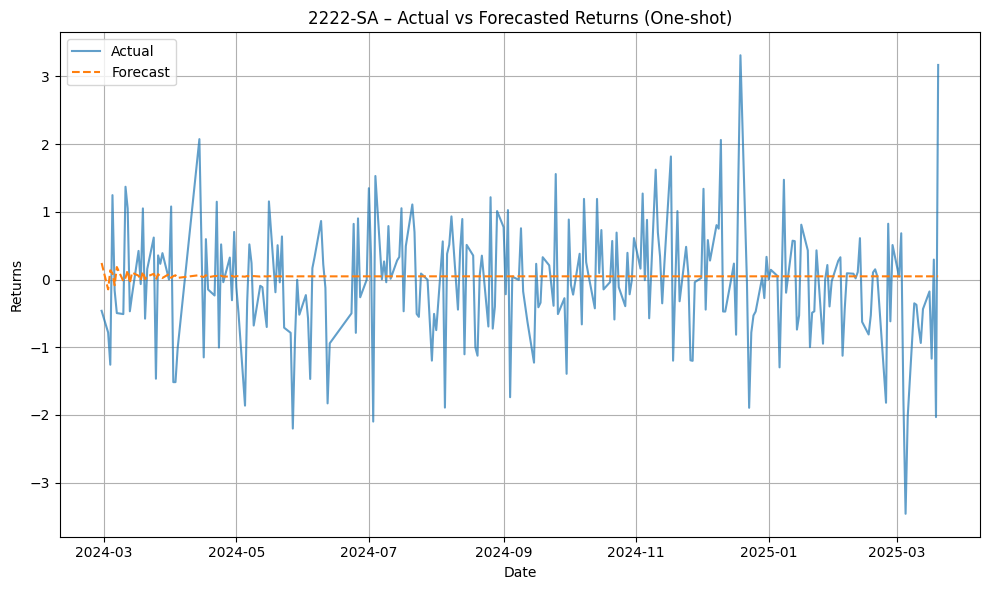

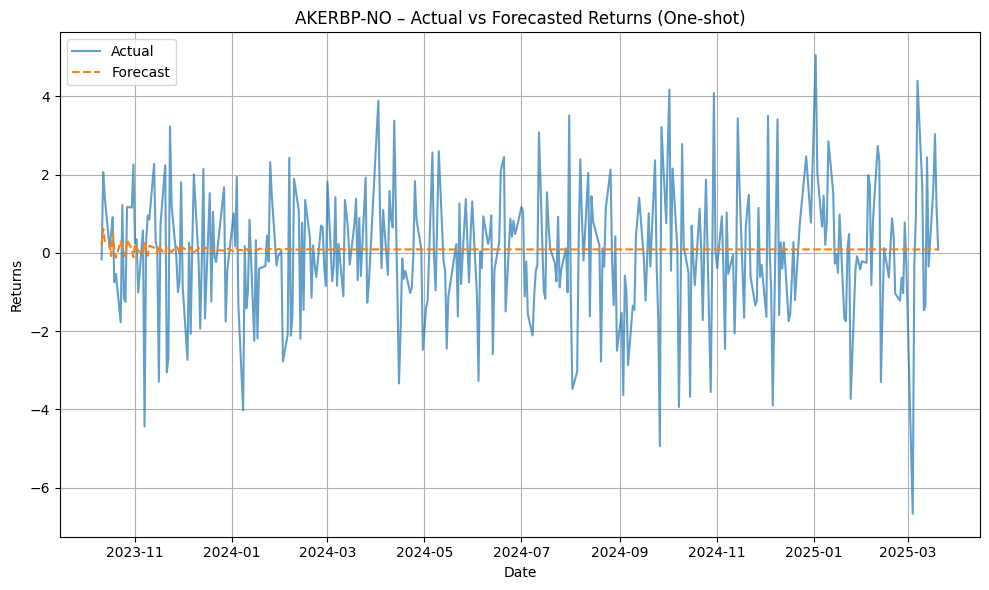

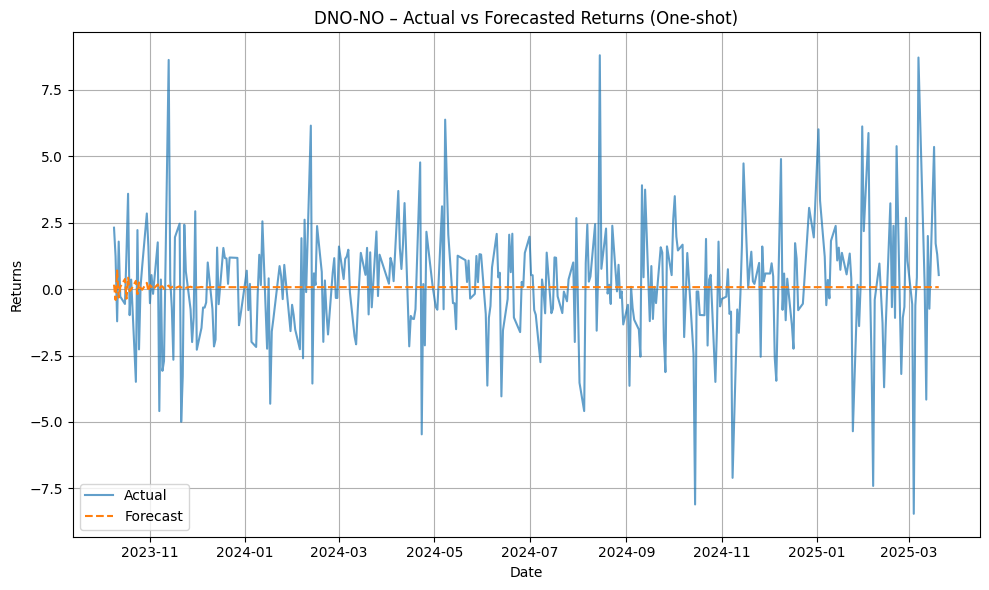

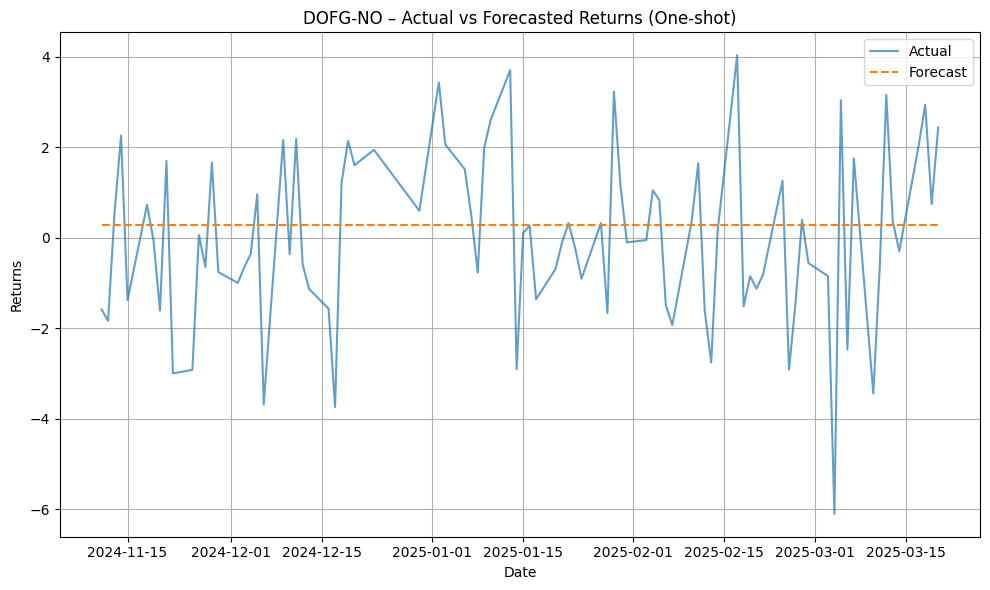

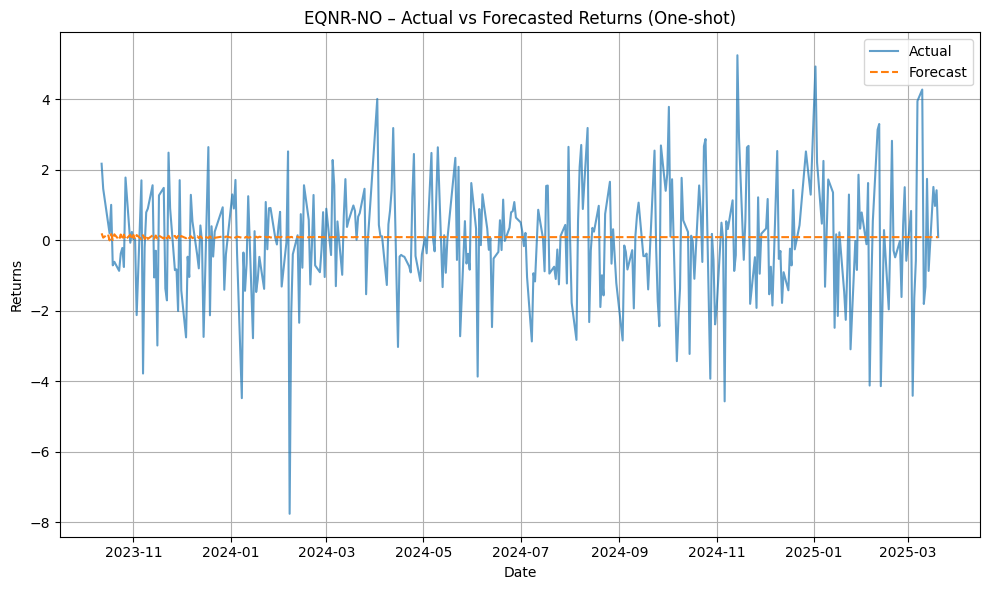

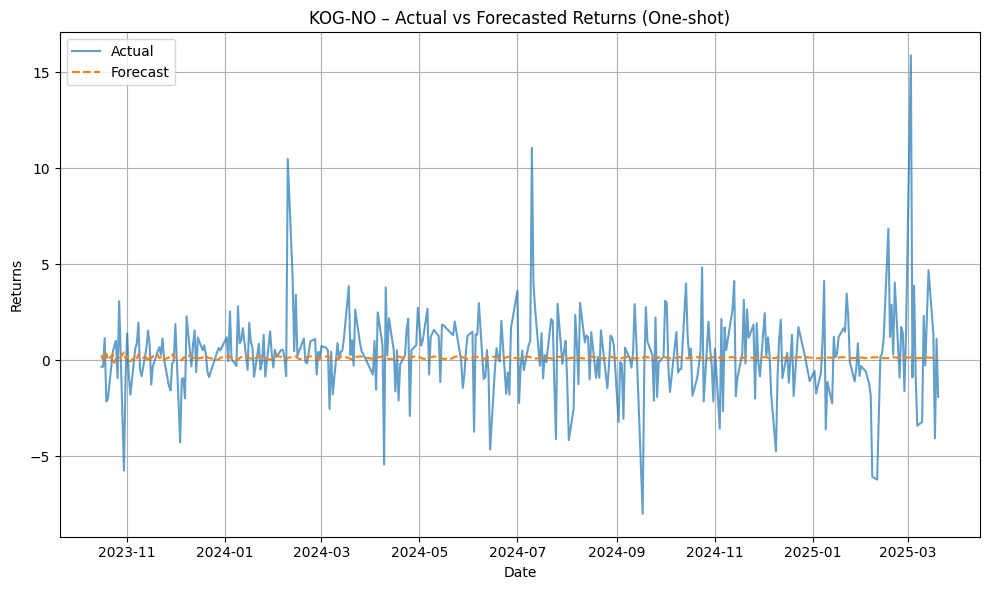

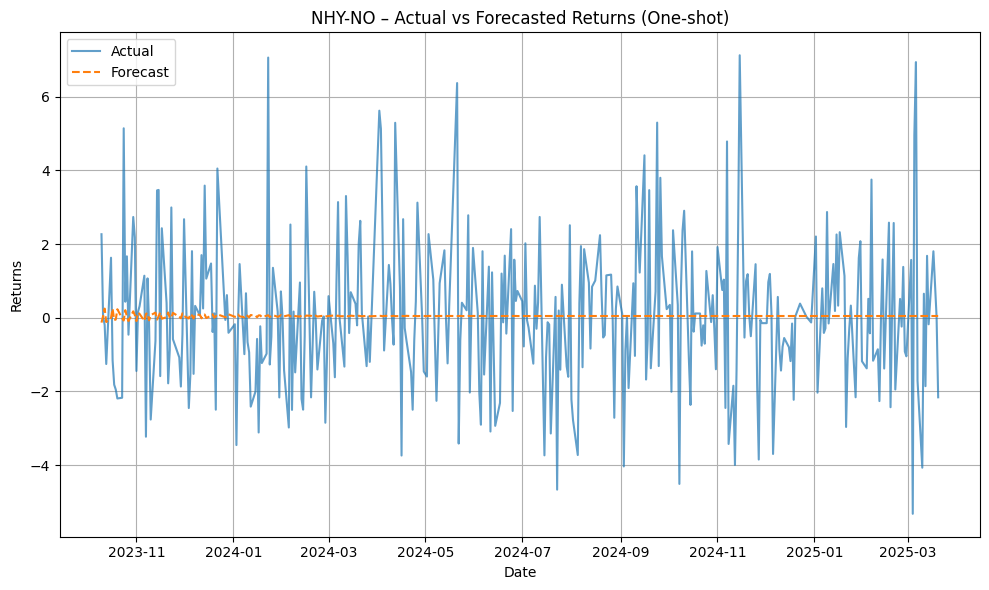

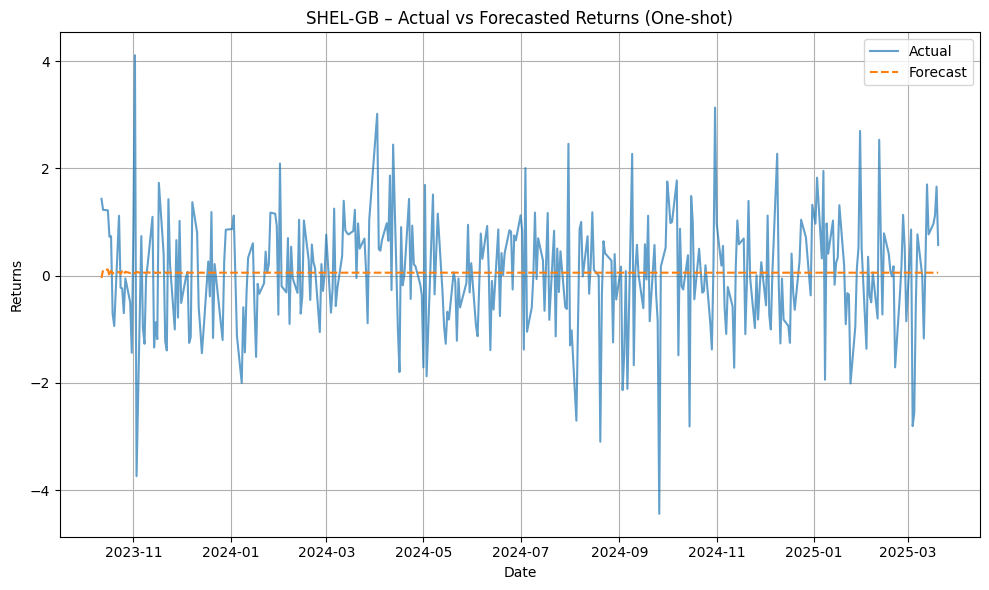

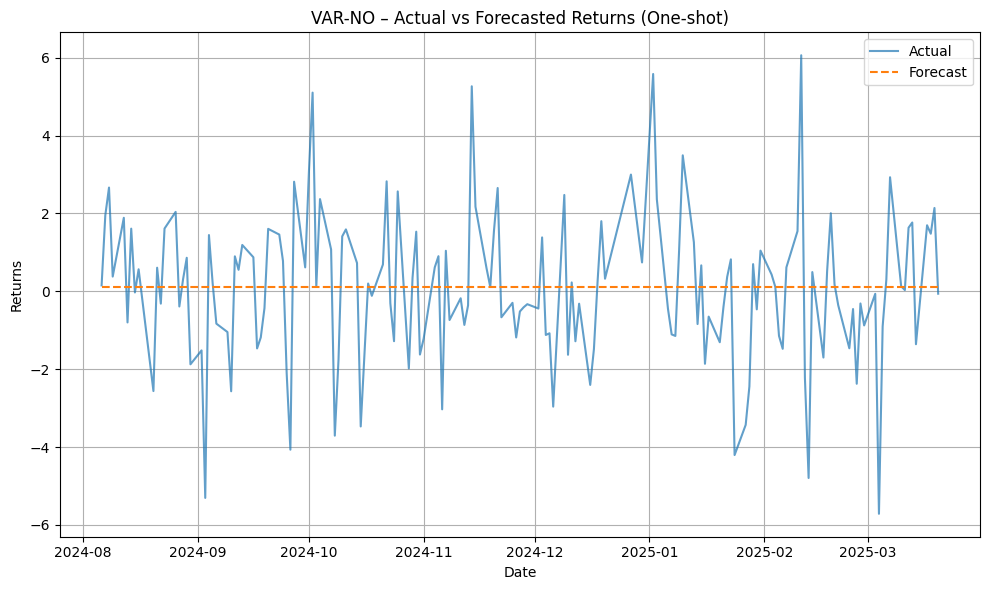

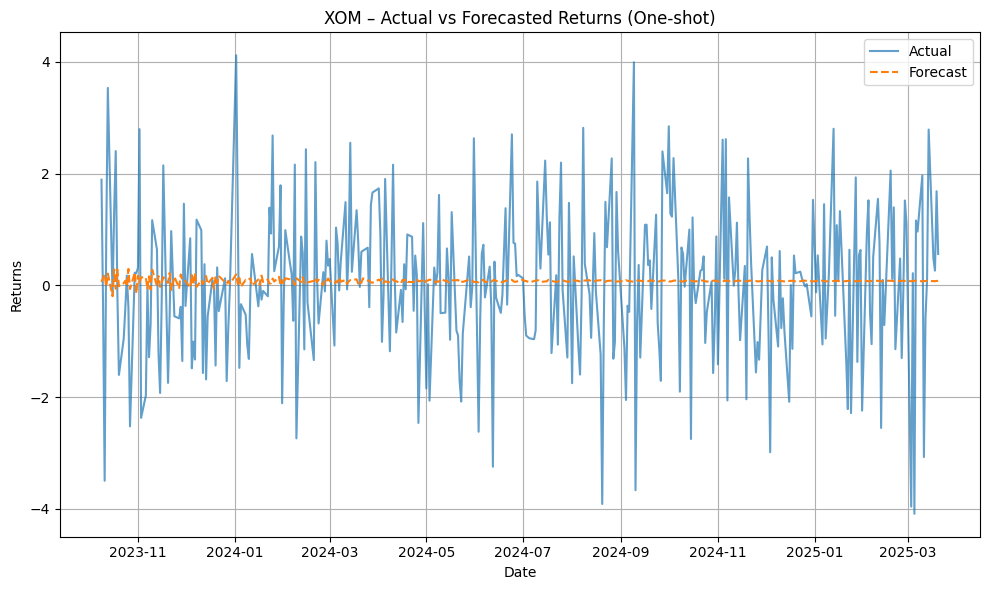

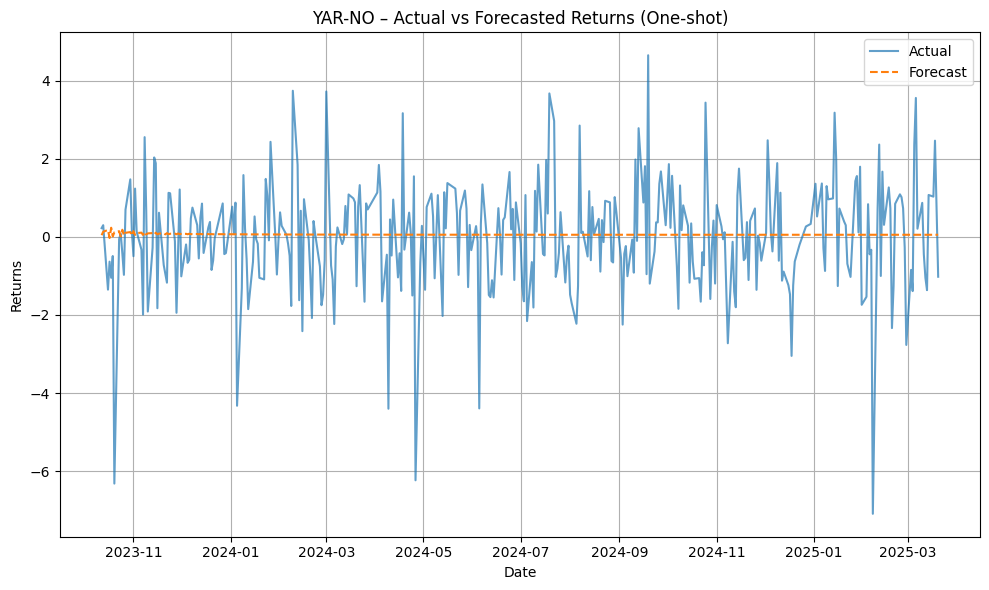

In [52]:
def plot_forecasts(data_dict):
    for key, value in data_dict.items():
        test_dates = value['test']['Date'].reset_index(drop=True)
        actual_returns = value['test']['Change_percent'].reset_index(drop=True)
        aic_forecast = pd.Series(value['AIC_forecast']).reset_index(drop=True)

        plt.figure(figsize=(10, 6))
        plt.plot(test_dates, actual_returns, label='Actual', alpha=0.7)
        plt.plot(test_dates, aic_forecast, label='Forecast', linestyle='--')

        plt.title(f"{key} – Actual vs Forecasted Returns (One-shot)")
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_forecasts(stock_one_prediction)


## Rolling window prediction

The poor performance of the one-shot-prediction ARMA models motivate the use of rolling training windows, where the model both is continuously updated with new data and solely focuses on short-term forecasting. This model fitting strategy leverages the properties of ARMA models in a better way. 

The rolling window prediction is constructed in the following way. The window-size is set to 100, which means that all ARMA models are fitted based on 100 days of past stock returns. Each ARMA model is used to only predict the next days’ stock returns. The first prediction, for example, is obtained by fitting an ARMA model on the first 100 days of stock returns, and then predicting the stock return of the 101st day of the dataset. To predict the stock return of day 102, the window is shifted forwards by one day. A new ARMA model is fitted on the stock returns from day 1 to day 101, and used to predict the stock return on day 102. This process continues until stock returns for all days, excluding the first 100 days (the first window), are predicted. As seen in the plots, this approach captures the movement of the stock returns in much higher accuracy, over the whole period of the time series. 

Visually, the rolling-window method seemingly offers much better predictions. The plots show that the predictions seemigly follow the actual values more accuratly. Although rolling window forecasts often visually align more closely with the actual series, they may result in higher RMSE values compared to one-shot predictions. This can be observed in the table below. Rolling models are re-estimated at each step using the most recent data, allowing them to better adapt to short-term dynamics and potentially shifting patterns in the time series. They operate as we would expect in real life: predictions are made best on the newest available data. However, this flexibility may cause more sensitivity to noise, leading to higher RMSE. On the other hand, one-shot models, especially those with minimal structure like ARIMA(0,0,0), often predict the mean of the series, which minimizes RMSE but lacks any informative predictive power. As we are interested in realistic, adaptive forecasting, rolling forecasts offer more value. Brooks highlights the limitation of RMSE in measuring predictive power, and suggeests other evaluation methods, discussed in section "Evaluating the Model". 


However, rolling predictions are way more computationally expensive than the one-shot predictions. Instead of fitting one ARMA model for each stock, each stock’s return is predicted using many ARMA models. In fact, a new ARMA model is fitted for every day, excluding the first 100 days of the time-series. This leads to much longer running times, with the whole prediction process taking 21 minutes in total for all stocks. 

To ensure code reproducibility, the below function also already supports ARIMAX integration.


In [ ]:
def evaluate_arima_or_arimax_rolling(data_dict, window_size=100, model_type="ARIMA", exog_key=None):
    """
    model_type: "ARIMA" or "ARIMAX"
    exog_key: name of the exogenous variable column (used only for ARIMAX)
    """
    results_summarized = pd.DataFrame()
    for key, value in data_dict.items():
        print(f"Processing {key} with model: {model_type}...")
        
        df = value['data'].copy()
        series = df['Change_percent']

        order = value['order'] 

        preds = []
        actuals = []
        residuals = []

        for i in range(window_size, len(series) - 1):
            train_window = series.iloc[i - window_size:i]
            test_point = series.iloc[i]

            try:
                if model_type == "ARIMAX":
                    exog_train = df[exog_key].iloc[i - window_size:i]
                    exog_test = df[exog_key].iloc[i + 0: i + 1]  # 1-step ahead

                    model = ARIMA(train_window, exog=exog_train, order=order).fit()
                    forecast = model.forecast(steps=1, exog=exog_test).iloc[0]

                else:  # ARIMA
                    model = ARIMA(train_window, order=order).fit()
                    forecast = model.forecast(steps=1).iloc[0]

                preds.append(forecast)
                actuals.append(test_point)
                residuals.append(test_point - forecast)

            except Exception as e:
                #Error at step {i}, do not let program crash, continue with predictions
                continue

        rmse = root_mean_squared_error(actuals, preds)
        
        #Calculate sign and flip accuracy
        sign_accuracy = np.mean(np.sign(actuals) == np.sign(preds))    

        actual_flips = np.sign(actuals[:-1]) != np.sign(actuals[1:])
        pred_flips = np.sign(preds[:-1]) != np.sign(preds[1:])
        correct_flips = actual_flips == pred_flips
        flip_accuracy = np.mean(correct_flips)
        

        # Save results
        value.update({
            f'{model_type}_Rolling_RMSE': rmse,
            f'{model_type}_Rolling_Predictions': preds,
            f'{model_type}_Rolling_Actuals': actuals,
            f'{model_type}_Rolling_Residuals': residuals,
            f'{model_type}_Rolling_Sign_Accuracy': sign_accuracy,
            f'{model_type}_Rolling_Flip_Accuracy': flip_accuracy

        })

        print(f"{key}: {model_type} RMSE = {rmse:.4f}")


        # Store results in a dataframe
        results_local = pd.DataFrame([{
            'Ticker': key,
            'Model': model_type,
            'RMSE': rmse,
            'Sign Accuracy': sign_accuracy,
            'Flip accuracy': flip_accuracy,
        }])

        # Append to the overall results
        results_summarized = pd.concat([results_summarized, results_local], ignore_index=True)
    
    return results_summarized

In [ ]:

#Train models for each ticker 
results_rolling_arima = evaluate_arima_or_arimax_rolling(stocks_dictionary, window_size=100, model_type="ARIMA", exog_key=None)

12543    3.917404
12544   -0.593954
12545    2.870865
12546   -0.627481
12547   -2.733920
           ...   
13856   -0.176152
13857   -1.168092
13858    0.294228
13859   -2.031552
13860    3.168168
Name: Change_percent, Length: 1318, dtype: float64
2222-SA - Error at step 434: LU decomposition error.
2222-SA: AIC RMSE = 1.2501, BIC RMSE = 1.2089
0       1.139178
1       1.371205
2       0.579710
3       0.672430
4       0.763359
          ...   
1788   -0.346616
1789    1.695645
1790    3.035491
1791    1.161822
1792    0.082037
Name: Change_percent, Length: 1793, dtype: float64
AKERBP-NO - Error at step 1585: LU decomposition error.
AKERBP-NO: AIC RMSE = 2.7984, BIC RMSE = 2.5781
7161    0.189474
7162    5.221685
7163   -1.148278
7164   -0.606061
7165    3.150407
          ...   
8951   -0.735884
8952    5.354190
8953    1.720104
8954    1.306682
8955    0.531107
Name: Change_percent, Length: 1795, dtype: float64
DNO-NO: AIC RMSE = 3.4307, BIC RMSE = 3.1889
16458   -3.154400
16459    

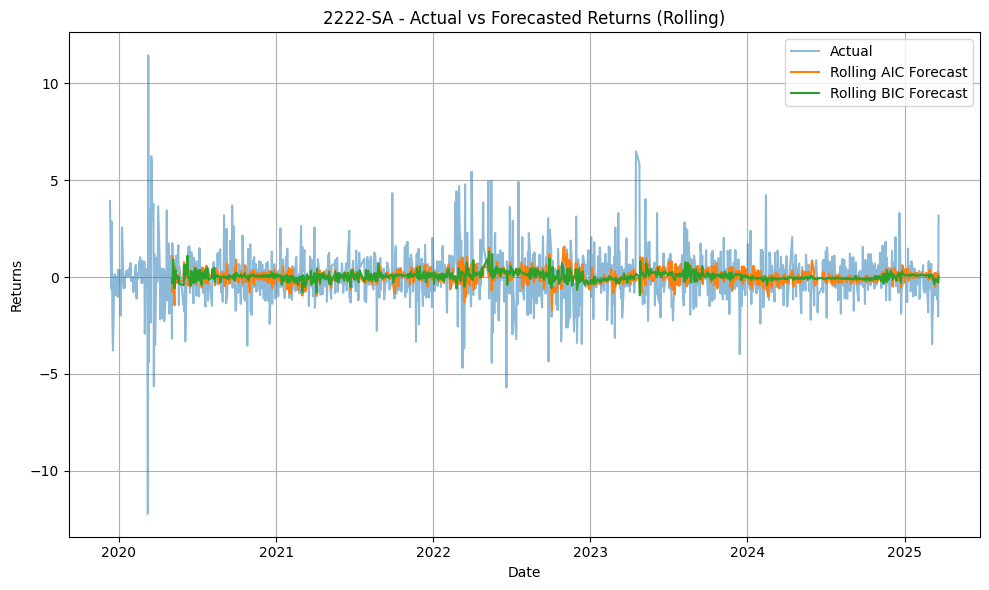

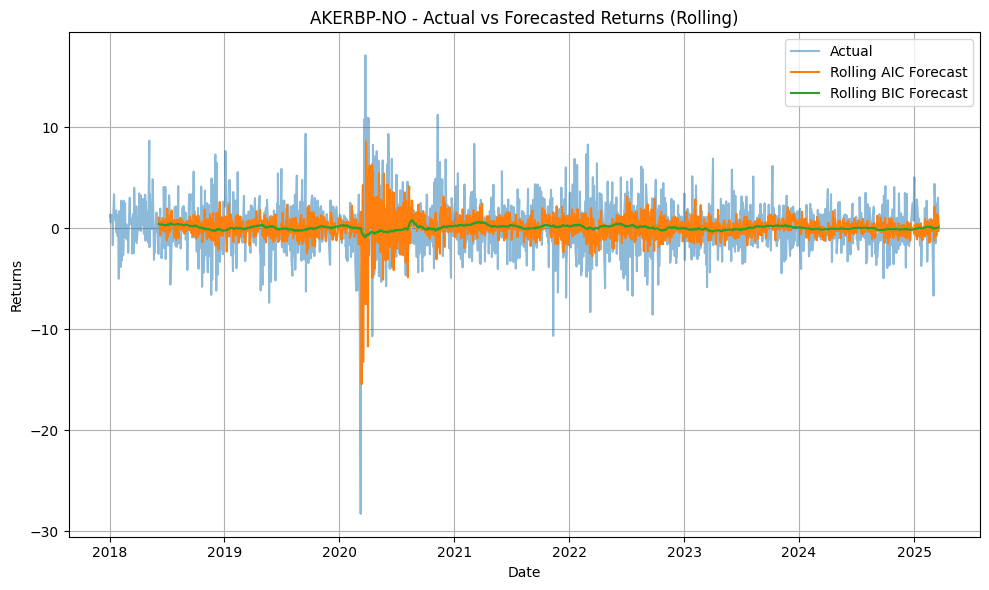

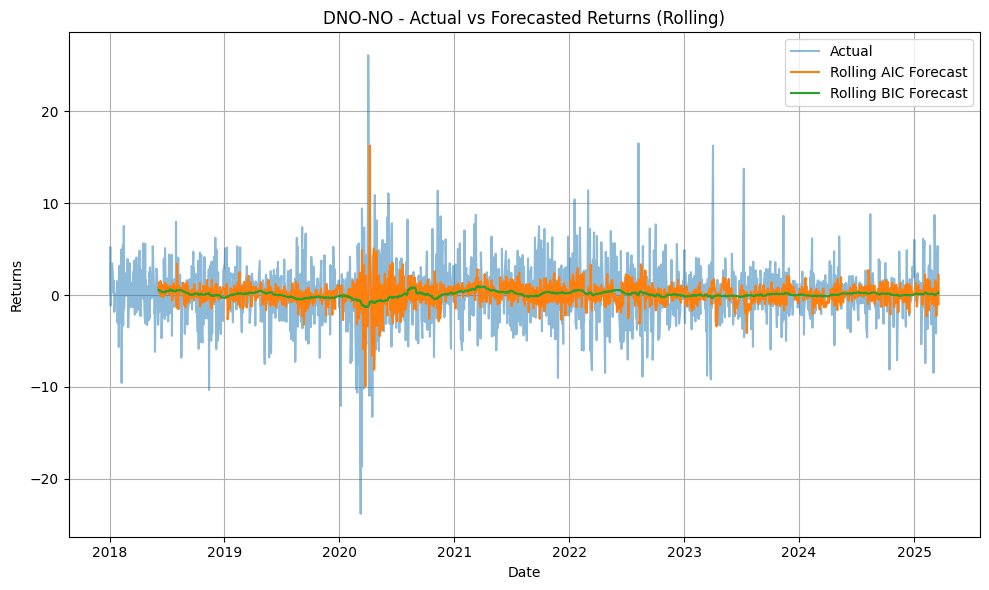

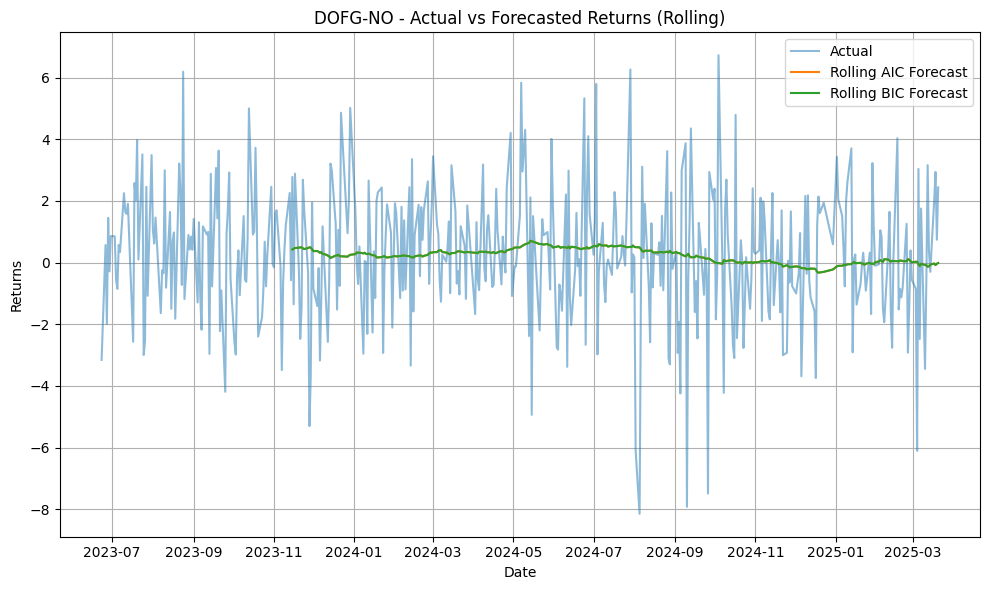

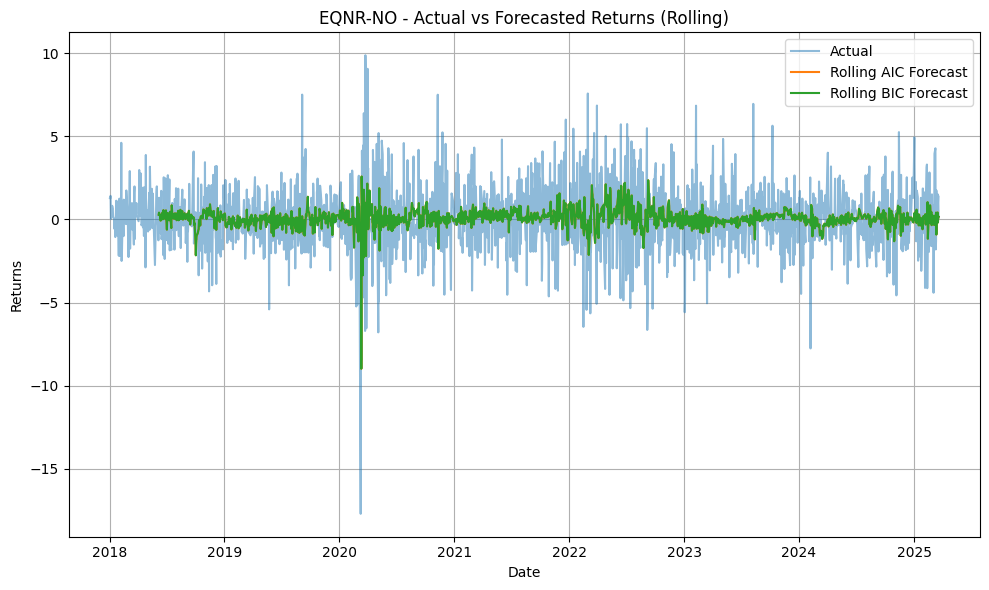

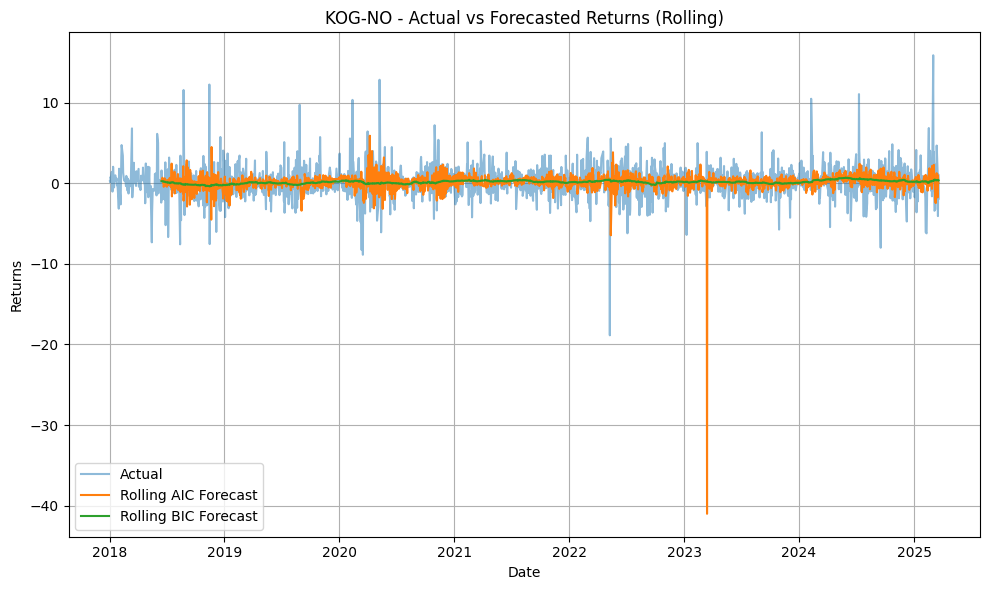

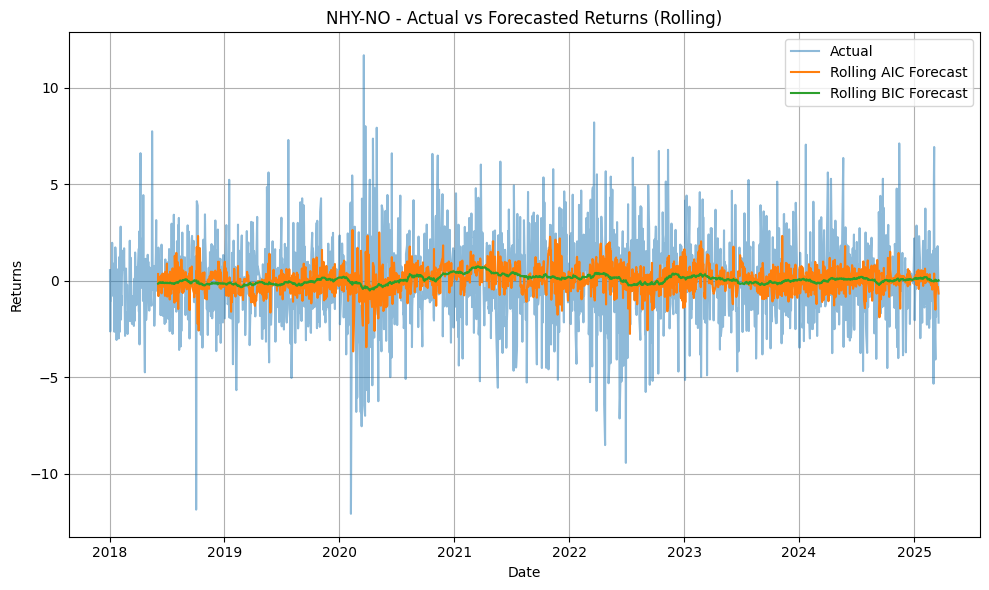

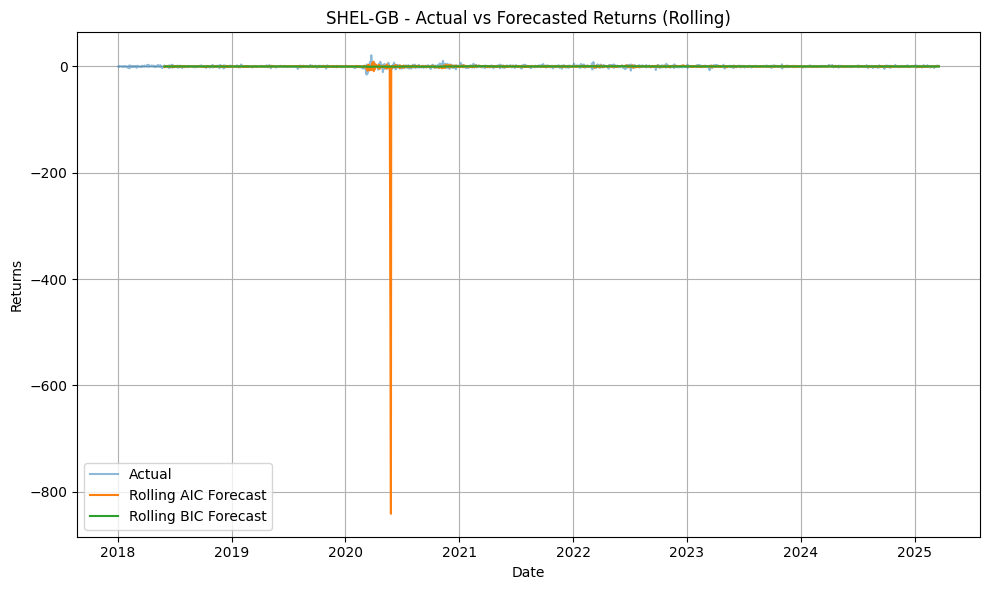

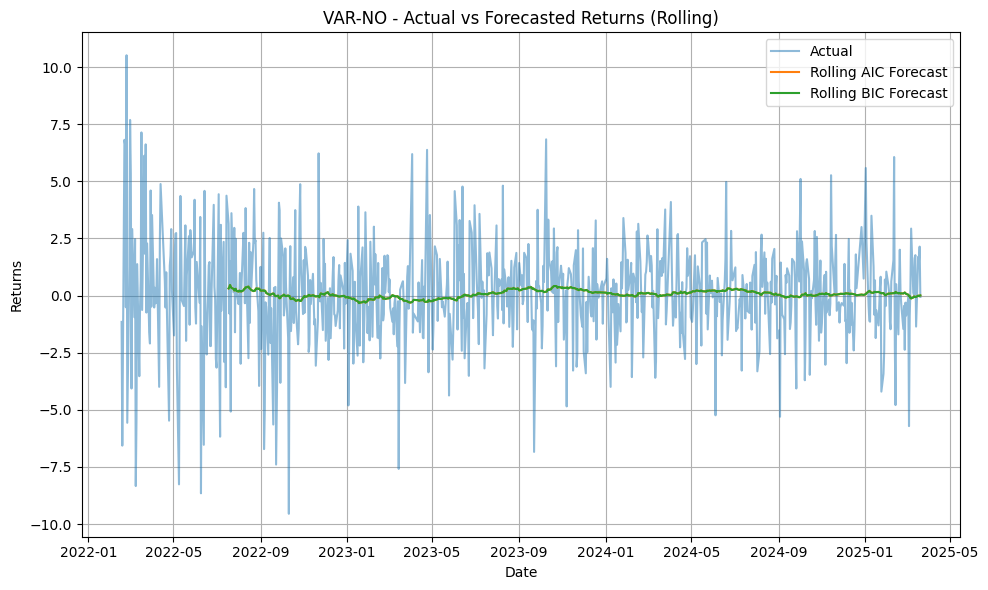

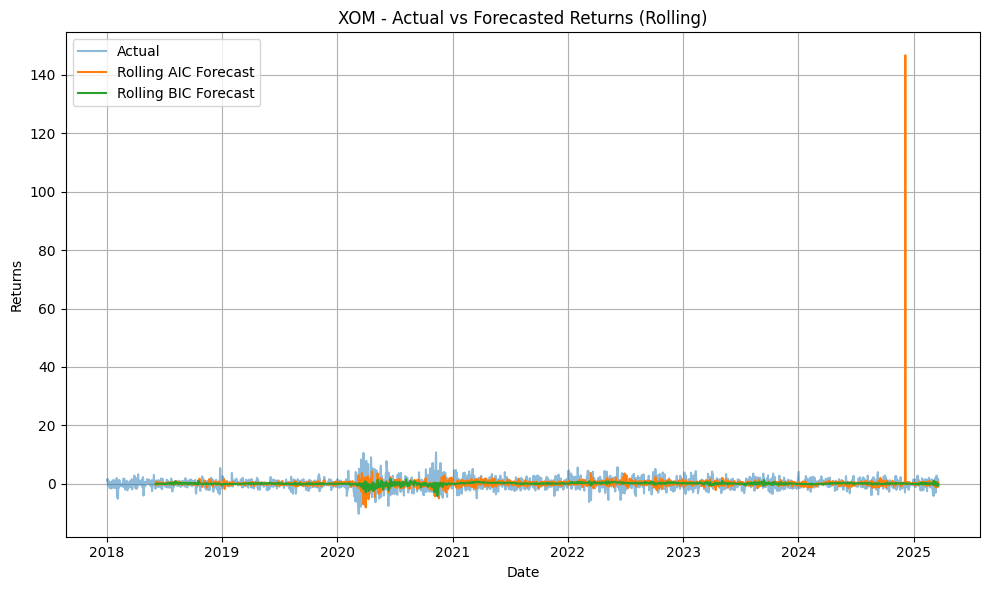

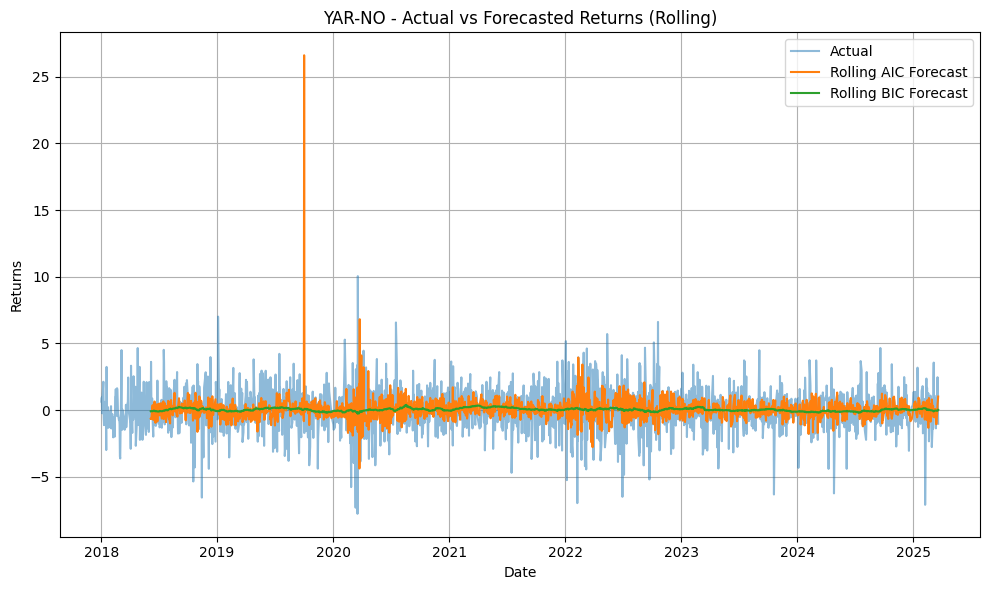

In [ ]:
#For each ticker, plot the actual vs forecasted values

for key, value in stocks_dictionary.items():
    preds = value['ARIMA_Rolling_Predictions']
    actuals = value['ARIMA_Rolling_Actuals']
    dates = value['data']['Date'][-len(actuals):].reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    plt.plot(dates, actuals, label='Actual Returns', alpha=0.6)
    plt.plot(dates, preds, label='ARIMA Rolling Forecast', alpha=0.8)
    plt.title(f"{key} – Actual vs ARIMA Rolling Forecast")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## ARIMAX prediction

Using the function above, we can run and plot the ARIMAX function. 

OBS HANS KRISTIAN: DETTE MÅ du ta med??



In [ ]:
#Train ARIMAX
results_arimax = evaluate_arima_or_arimax_rolling(stocks_dictionary, window_size=100, model_type="ARIMAX", exog_key=None)


Processing 2222-SA with model: ARIMA...
{'data':             Date  Change_percent
12543 2019-12-12        3.917404
12544 2019-12-15       -0.593954
12545 2019-12-16        2.870865
12546 2019-12-17       -0.627481
12547 2019-12-18       -2.733920
...          ...             ...
13856 2025-03-16       -0.176152
13857 2025-03-17       -1.168092
13858 2025-03-18        0.294228
13859 2025-03-19       -2.031552
13860 2025-03-20        3.168168

[1318 rows x 2 columns], 'order': (2, 0, 2)}
2222-SA - Error at step 434: LU decomposition error.
2222-SA: ARIMA RMSE = 1.2501
Processing AKERBP-NO with model: ARIMA...
{'data':            Date  Change_percent
0    2018-01-02        1.139178
1    2018-01-03        1.371205
2    2018-01-04        0.579710
3    2018-01-05        0.672430
4    2018-01-08        0.763359
...         ...             ...
1788 2025-03-14       -0.346616
1789 2025-03-17        1.695645
1790 2025-03-18        3.035491
1791 2025-03-19        1.161822
1792 2025-03-20        0

,Ticker,Model,RMSE,Sign Accuracy,Flip accuracy
0,2222-SA,ARIMA,1.250084,0.496711,0.516049
1,AKERBP-NO,ARIMA,2.798418,0.499704,0.479882
2,DNO-NO,ARIMA,3.430697,0.490555,0.500886
3,DOFG-NO,ARIMA,2.203927,0.514881,0.480597
4,EQNR-NO,ARIMA,2.069162,0.494991,0.493514
5,KOG-NO,ARIMA,2.362517,0.509970,0.495768
6,NHY-NO,ARIMA,2.399997,0.515708,0.471530
7,SHEL-GB,ARIMA,20.319223,0.512776,0.513074
8,VAR-NO,ARIMA,2.029415,0.519345,0.523100
9,XOM,ARIMA,4.152770,0.488005,0.515808


In [ ]:
#Plot ARIMAX
#For each ticker, plot the actual vs forecasted values

for key, value in stocks_dictionary.items():
    preds = value['ARIMAX_Rolling_Predictions']
    actuals = value['ARIMAX_Rolling_Actuals']
    dates = value['data']['Date'][-len(actuals):].reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    plt.plot(dates, actuals, label='Actual Returns', alpha=0.6)
    plt.plot(dates, preds, label='ARIMAX Rolling Forecast', alpha=0.8)
    plt.title(f"{key} – Actual vs ARIMAX Rolling Forecast")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Evaluate Model
Up until now, the model’s have largely been evaluated on a visual basis. However, it is essential to define metrics which quantify how accurate a prediction is. This can be done using the Root Mean Squared Error (RMSE) metric, which is common to use in prediction evaluation. The advantage of RMSE compared to MSE is that it is in the same unit as the original data. For financial forecasting, however, it may be more appropriate to use metrics which capture how well a model predicts the sign of future return or turning points in a series (Books, pg.287). Imagine the actual return being 3%, and we have two different predictions to evaluate: -2% and 9%. RMSE would prefer the first prediction, as it is numerically closer to the actual return.

However, in a financial context, the +9% prediction may be more useful, as it correctly predicts a positive return, potentially leading to the right trading decision. Therefore, this project also used share of correctly predicted signs of future returns and correctly predicted turning points as an evaluation metric. This is already implemented in the arima_arimax_modelling function. 

In [ ]:
#Summary of the results as dataframe


,Ticker,AIC_RMSE,BIC_RMSE,Rolling_AIC_RMSE,Rolling_BIC_RMSE,AIC_Sign_Accuracy,Rolling_AIC_Sign_Accuracy,Rolling_BIC_Sign_Accuracy,BIC_Sign_Accuracy,AIC_Flip_Accuracy,BIC_Flip_Accuracy,Rolling_AIC_Flip_Accuracy,Rolling_BIC_Flip_Accuracy
0,2222-SA,0.870929,0.871896,1.250084,1.208944,0.500000,0.496711,0.520559,0.477273,0.486692,0.479087,0.516049,0.466667
1,AKERBP-NO,1.646457,1.644469,2.798418,2.578125,0.487465,0.499704,0.496156,0.495822,0.483240,0.500000,0.479882,0.496450
2,DNO-NO,2.218782,2.215786,3.430697,3.188908,0.526462,0.490555,0.488194,0.537604,0.564246,0.541899,0.500886,0.504430
3,DOFG-NO,1.927816,1.927816,2.203927,2.203927,0.488636,0.514881,0.514881,0.488636,0.482759,0.482759,0.480597,0.480597
4,EQNR-NO,1.632902,1.632902,2.069162,2.069162,0.494444,0.494991,0.494991,0.494444,0.520891,0.520891,0.493514,0.493514
5,KOG-NO,2.196893,2.196245,2.362517,2.055572,0.602273,0.509970,0.516616,0.599432,0.515670,0.532764,0.495768,0.493349
6,NHY-NO,2.016578,2.015112,2.399997,2.315578,0.497207,0.515708,0.499111,0.491620,0.434174,0.448179,0.471530,0.477461
7,SHEL-GB,1.063787,1.063482,20.319223,1.831040,0.528767,0.512776,0.519744,0.534247,0.497253,0.505495,0.513074,0.515979
8,VAR-NO,1.919051,1.919051,2.029415,2.029415,0.529032,0.519345,0.519345,0.529032,0.590909,0.590909,0.523100,0.523100
9,XOM,1.336063,1.334053,4.152770,1.886408,0.523416,0.488005,0.503218,0.523416,0.469613,0.475138,0.515808,0.498244


## Check for autocorrelation in residuals 
As described by Brooks (2019, pg.270), the last step of the Box-Jenkins approach involves residual diagnostics. In this context, diagnostic testing is limited to testing for autocorrelation. Autocorrelation can be an indication that the ARMA model fails to capture the time-dependent structure of the data. This can for example be due to a too simple model specification. Testing for autocorrelation can be done using the Ljung-Box test, where the null hypothesis is that the model’s residuals are not autocorrelated, in other words they resemble white noise. 


In [ ]:
#Perform the Ljun-Box test for each ticker
from statsmodels.stats.diagnostic import acorr_ljungbox

for key, value in stock_one_prediction.items():
    aic_ljung_non_rolling = acorr_ljungbox(np.array(value['AIC_model'].resid), lags=20, return_df=True)
    bic_ljung_non_rolling = acorr_ljungbox(np.array(value['BIC_model'].resid), lags=20, return_df=True)


    aic_ljung_rolling = acorr_ljungbox(np.array(value['AIC_Residuals']), lags=20, return_df=True)
    bic_ljung_rolling = acorr_ljungbox(np.array(value['BIC_Residuals']), lags=20, return_df=True)

    #Update the dictionary
    #https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
    value.update({
        'AIC_NonRolling_autocorrelation': aic_ljung_non_rolling['lb_pvalue'].iloc[-1] <= 0.05,
        'BIC_NonRolling_autocorrelation': bic_ljung_non_rolling['lb_pvalue'].iloc[-1] <= 0.05,

        'AIC_Rolling_autocorrelation': aic_ljung_rolling['lb_pvalue'].iloc[-1] <= 0.05,
        'BIC_Rolling_autocorrelation': bic_ljung_rolling['lb_pvalue'].iloc[-1] <= 0.05
    })

    

In [ ]:
#Summary
results = []
for key, value in stock_one_prediction.items():
    results.append({
        'Ticker': key,
        'AIC_NonRolling_Autocorrelation': value['AIC_NonRolling_autocorrelation'],
        'BIC_NonRolling_Autocorrelation': value['BIC_NonRolling_autocorrelation'],
        'AIC_Rolling_Autocorrelation': value['AIC_Rolling_autocorrelation'],
        'BIC_Rolling_Autocorrelation': value['BIC_Rolling_autocorrelation']
    })

df = pd.DataFrame(results)
display(df)

,Ticker,AIC_NonRolling_Autocorrelation,BIC_NonRolling_Autocorrelation,AIC_Rolling_Autocorrelation,BIC_Rolling_Autocorrelation
0,2222-SA,False,True,False,False
1,AKERBP-NO,False,True,False,True
2,DNO-NO,False,True,False,True
3,DOFG-NO,False,False,False,False
4,EQNR-NO,True,True,True,True
5,KOG-NO,False,False,False,True
6,NHY-NO,False,False,False,False
7,SHEL-GB,False,True,False,True
8,VAR-NO,False,False,False,False
9,XOM,False,True,False,True
